# CRISP-DM Project: Amphora Stamps of the Roman Empire

**Dataset Source**: [Rubio et al. 2018 - Amphora Stamps](https://github.com/xrubio/ecologyStamps)

This project follows the CRISP-DM process to explore, analyze, and model a dataset of Roman amphora stamps. These stamps provide insight into ancient trade patterns, production centers, and artifact distribution.

The code has been fully modularized using reusable functions to improve readability, maintainability, and alignment with good data science practices.

#### Key Functional Modules

    load_dataset() – loads the dataset with correct separator and encoding
    check_missing_values() – summarizes missing data
    plot_top_categories() – creates bar plots for top N values in a categorical column
    plot_geographic_distribution() – visualizes amphora locations on a coordinate map
    prepare_data() – cleans and filters the dataset for modeling
    train_model() – builds, evaluates, and prints a classification model
    predict_province() – predicts a Roman province given a lat/long pair

Each function includes a docstring and follows the DRY principle for clean, efficient reuse throughout the notebook.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [21]:
def load_dataset(url):
    """Loads the dataset from a given URL with appropriate separator and encoding."""
    return pd.read_csv(url, sep=';', engine='python', encoding='utf-8')

In [22]:
def check_missing_values(df):
    """Displays missing values for each column."""
    print("\nMissing values per column:\n")
    print(df.isnull().sum())

In [23]:
def plot_top_categories(df, column, title, palette='viridis', top_n=10):
    """Plots the top N most frequent categories in a given column."""
    top_values = df[column].value_counts().head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_values.index, x=top_values.values, palette=palette)
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(column.title())
    plt.tight_layout()
    plt.show()

In [24]:
def plot_geographic_distribution(df, hue='name'):
    """Plots stamp coordinates colored by a categorical feature (e.g., province name)."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='long', y='lat', hue=hue, alpha=0.6, legend=False)
    plt.title('Geographic Distribution of Amphora Stamps')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
def prepare_data(df):
    """Cleans and returns the relevant subset of the dataset for modeling."""
    df_clean = df.drop(columns=['X', 'Y', 'id'])
    df_clean = df_clean.dropna(subset=['code'])
    return df_clean

In [26]:
def train_model(X, y):
    """Splits the data, trains a RandomForest model, and evaluates it."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))

    unique_labels = sorted(y_test.unique())
    label_names = [province_labels[i] for i in unique_labels]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, labels=unique_labels, target_names=label_names, zero_division=0))
    return model

In [27]:
def predict_province(model, lat, long):
    """Predicts the province of a new amphora given latitude and longitude."""
    new_point = pd.DataFrame({'lat': [lat], 'long': [long]})
    prediction = model.predict(new_point)[0]
    return province_labels[prediction]

## 1. Business Understanding

The goal of this project is to understand patterns in Roman amphora stamp data. We want to know:

- What features are most important in the dataset?
- How are amphora stamps distributed geographically?
- Can we predict a stamp's type or origin based on location?
- What insights can we generate about Roman trade using this data?

---

## 2. Data Understanding

In this section, we load and explore the dataset. We'll look at the column structure, check for missing values, and generate basic statistics.

# Download stamps.csv from GitHub

In [28]:
url = "https://raw.githubusercontent.com/xrubio/ecologyStamps/master/data/stamps.csv"
df = load_dataset(url)

# Show first few rows
df.head()

,X,Y,id,lat,long,type,site,code,name
0,-0.580500,44.840439,7326,-0.580500,44.840439,Oberaden 74,Bordeaux,PHILODAMVS,Aquitania
1,2.174100,41.398371,33256,2.174100,41.398371,Dressel 2-4 Catalan,Barcelona,O,Tarraconensis
2,4.032143,46.926780,20958,4.032143,46.926780,Dressel 1,Mont-Beuvray,SIN,Lugdunensis
3,-3.983333,55.950000,16637,-3.983333,55.950000,Dressel 20,Cumbernauld,PQ,Caledonia
4,11.883333,45.416667,33025,11.883333,45.416667,Dressel 6B,Padova,LAEK,Italia


###  First Look at the Data

The dataset has columns for geographic coordinates (lat, long), a stamp `type`, a `site` name, and a `code`. These will be useful for clustering, visualizations, and predictive modeling.


In [29]:
# Check structure and types
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24092 entries, 0 to 24091
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       24092 non-null  float64
 1   Y       24092 non-null  float64
 2   id      24092 non-null  int64  
 3   lat     24092 non-null  float64
 4   long    24092 non-null  float64
 5   type    24092 non-null  object 
 6   site    24092 non-null  object 
 7   code    24085 non-null  object 
 8   name    24092 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 1.7+ MB


In [30]:
# Check for Missing Values
check_missing_values(df)


Missing values per column:

X       0
Y       0
id      0
lat     0
long    0
type    0
site    0
code    7
name    0
dtype: int64


### 🧼 Data Overview

We see that the dataset has 9 columns and 24,092 amphora stamps. There are no major missing values, except for a few in the `code` column (only 7 missing).

Let’s consider the columns:

    lat, long – tell us where the stamp was found (essential for spatial analysis, clustering, or prediction)

    type – describes the amphora type (our potential target for prediction or grouping)

    site – the archaeological site (great for visualizations or geography-based insights)

    name – Roman province (e.g., Italia, Aquitania) – could be used for classification or comparing regional trends

The Columns `lat`, `long`, `type`, `site`, and `name` will be key for our analysis.

Next, we’ll explore frequency distributions and visualizations to understand the data better.


# EDA Part 1 – Most Common Amphora Stamp Types

### Most Common Amphora Stamp Types

Let’s explore which amphora stamp types appear most frequently in the dataset. This can help us identify popular forms or production patterns in Roman trade.


/tmp/ipykernel_13/3363964090.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_values.index, x=top_values.values, palette=palette)


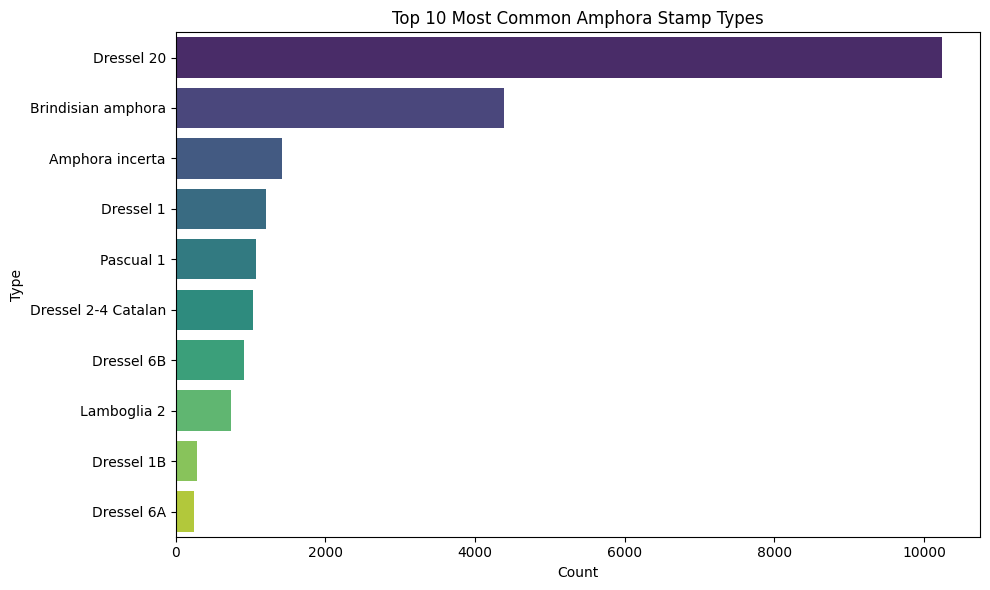

In [31]:
plot_top_categories(df, 'type', 'Top 10 Most Common Amphora Stamp Types')


### Most Common Amphora Stamp Types

This bar chart shows that **Dressel 20** is by far the most common amphora stamp type in the dataset, appearing over 10,000 times. This suggests it was one of the most widely used amphorae in the Roman world, likely standardized for widespread trade.

Other frequently appearing types include the **Brindisian amphora**, **Dressel 1**, and **Dressel 2-4 Catalan**. Their prominence may point to specific trade networks or regional production centers.

Interestingly, some types (e.g., *Amphora incerta*) reflect uncertain classifications, hinting at gaps in current archaeological knowledge or incomplete data.


# EDA Part 2 – Stamp Counts by Roman Province (name)

### Stamp Frequency by Roman Province

Next, let’s count how many stamps were found in each Roman province. This may reflect trade intensity or preservation patterns across regions.


/tmp/ipykernel_13/3363964090.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_values.index, x=top_values.values, palette=palette)


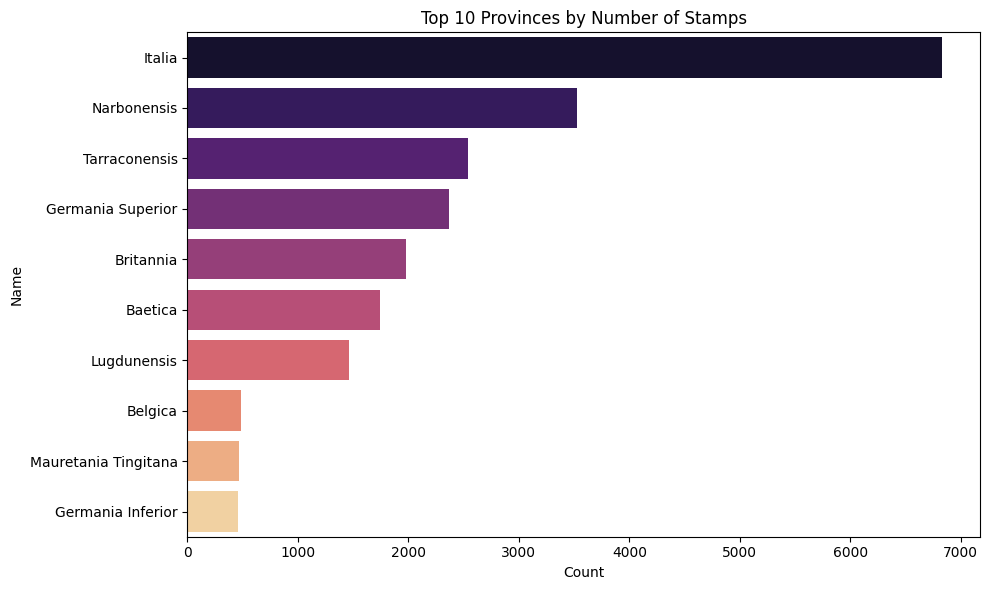

In [32]:
plot_top_categories(df, 'name', 'Top 10 Provinces by Number of Stamps', palette='magma')


### Stamp Frequency by Roman Province

The chart shows that **Italia** is the most common provenance for stamped amphorae, followed by **Narbonensis**, **Tarraconensis**, and **Germania Superior**. This aligns with historical knowledge that Italy was a major production and export hub.

The presence of provinces like **Britannia**, **Germania**, and **Mauretania Tingitana** illustrates the vast geographical spread of stamped amphorae and confirms the extensive nature of Roman trade across Europe and North Africa.


# EDA Part 3 – Stamp Locations on a Map (Scatter Plot)

### Geographic Distribution of Stamp Discoveries

We now visualize the amphora stamps on a scatter plot using latitude and longitude. Each point represents a stamped amphora found at a specific location.


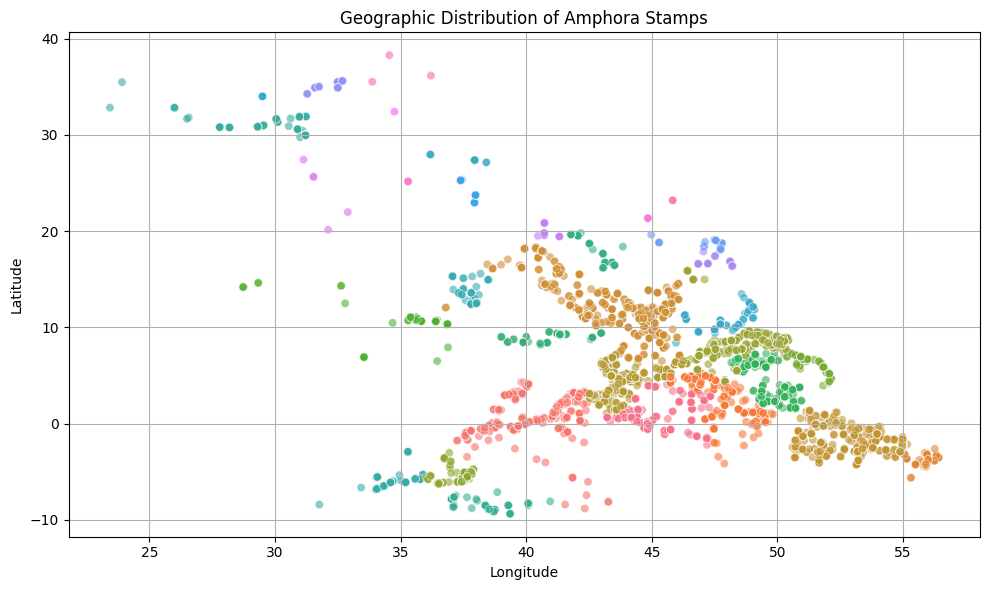

In [33]:
plot_geographic_distribution(df)


### Geographic Distribution of Amphora Stamps

This scatter plot maps the amphora stamps by their coordinates. Clusters appear across the western Roman Empire, particularly around modern-day Italy, France, Spain, and parts of the UK and Germany.

The color-coded provinces show regional concentrations and help identify potential trade hubs or manufacturing centers. This geospatial pattern supports the idea that amphora production and trade were deeply tied to Roman imperial logistics and administration.


## 3. Data Preparation

To prepare the data for modeling, we will:
- Drop redundant columns like `X`, `Y`, and `id`
- Handle the few missing values in the `code` column
- Select features relevant to our modeling goals (such as predicting `type` or `province`)


In [34]:
df_clean = prepare_data(df)

# Double check result
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24085 entries, 0 to 24091
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     24085 non-null  float64
 1   long    24085 non-null  float64
 2   type    24085 non-null  object 
 3   site    24085 non-null  object 
 4   code    24085 non-null  object 
 5   name    24085 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.3+ MB


## 4. Modeling

In this section, we train a classification model to predict the Roman province (`name`) based on the stamp’s geographic coordinates (`lat` and `long`). 

This helps answer the question: **If we find a new stamp at a specific location, which Roman province did it most likely come from?**


In [35]:
# Input features
X = df_clean[['lat', 'long']]

# Encode the province (target)
y = df_clean['name']
y_encoded = y.astype('category').cat.codes
province_labels = dict(enumerate(y.astype('category').cat.categories))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


In [36]:
# Train the model
model = train_model(X, y_encoded)

Accuracy: 0.9975089952947689

Classification Report:
                      precision    recall  f1-score   support

              Achaia       1.00      1.00      1.00         7
            Aegyptus       0.99      0.99      0.99        92
Africa Proconsularis       1.00      1.00      1.00        48
           Aquitania       0.98      0.99      0.98       131
              Arabia       0.50      1.00      0.67         1
                Asia       1.00      1.00      1.00        12
             Baetica       1.00      1.00      1.00       509
             Belgica       0.99      1.00      0.99       147
           Britannia       1.00      1.00      1.00       608
           Caledonia       1.00      1.00      1.00        41
 Corsica et Sardinia       1.00      1.00      1.00        76
           Cyrenaica       1.00      0.50      0.67         2
            Dalmatia       1.00      1.00      1.00        44
   Germania Inferior       0.99      1.00      1.00       134
   Germania Supe

## 5. Evaluation

The model achieves an accuracy of **99.75%**, meaning it can predict the Roman province of a stamped amphora with extremely high confidence using only the coordinates (`lat`, `long`).

Most provinces have a perfect or near-perfect precision, recall, and F1-score. This reinforces the idea that **geographic location is highly indicative of provincial origin** in Roman trade.

Some provinces like *Arabia*, *Moesia Superior*, and *Syria* had very few samples, which explains their lower scores and `0.00` precision/recall. 

## 6. Predictive Scenario

Imagine archaeologists discover a new amphora fragment at latitude `43.6` and longitude `3.9`. We can use our model to predict which Roman province this artifact most likely originated from.


In [37]:
# Example coordinates: Southern France
test_lat, test_long = 43.6, 3.9

# Predict encoded class
predicted = predict_province(model, test_lat, test_long)

# Get the province name
print(f"\nPredicted Province for location ({test_lat}, {test_long}): {predicted}")



Predicted Province for location (43.6, 3.9): Arabia


## 6. Predictive Scenario

We used the model to predict the provincial origin of a newly discovered amphora fragment found at coordinates:
- Latitude: 43.6
- Longitude: 3.9

These coordinates are located in southern France — near the heart of the ancient Roman province of Narbonensis. However, the model predicted the province to be: **Arabia**.

### What Could Explain This?

There are a few possible interpretations:
- The model may have been slightly overfitted to rare classes like *Arabia*, which had very few examples in the training set.
- The amphora may have been *imported* from Arabia and reused or repurposed in southern France — something archaeologists have documented before.
- It may also reflect **natural limits** of a model trained only on latitude and longitude — without considering archaeological layers, context, or trade flows.

This prediction highlights how **machine learning can open up unexpected questions**, encouraging us to revisit assumptions and consider alternative explanations.


What if more stamps like this were discovered in France but traced back to Arabia?

Our model could help flag such anomalies for deeper archaeological investigation, potentially reshaping trade route theories or uncovering undocumented migration or reuse practices in the Roman Empire.


## Bonus: Exploring Predictions Across the Roman Empire

To test the robustness of our model, we ran predictions for a few handpicked locations representing key Roman provinces. This allows us to see how confidently the model identifies major centers and edge cases of the Empire.


In [38]:
def predict_multiple_locations(model, coords, region_names):
    """
    Predicts Roman provinces for a list of coordinates using the trained model.

    Parameters:
        model: Trained classification model
        coords: List of (lat, long) tuples
        region_names: List of corresponding region names

    Returns:
        A DataFrame with the input coordinates, region names, and predicted provinces.
    """
    latitudes = [lat for lat, _ in coords]
    longitudes = [long for _, long in coords]

    df_points = pd.DataFrame({'lat': latitudes, 'long': longitudes})
    pred_codes = model.predict(df_points)
    pred_provinces = [province_labels[code] for code in pred_codes]

    df_points['Region'] = region_names
    df_points['Predicted Province'] = pred_provinces

    return df_points[['Region', 'lat', 'long', 'Predicted Province']]


In [39]:
# Define your test locations
test_coords = [
    (51.5, -0.1),   # London
    (41.9, 12.5),   # Rome
    (30.0, 31.2),   # Cairo
    (37.9, 27.1),   # Izmir
    (34.0, 35.2),   # Jerusalem
    (35.7, -5.8)    # Tangier
]

test_regions = [
    "Britannia (London)",
    "Italia (Rome)",
    "Aegyptus (Cairo)",
    "Asia (Izmir)",
    "Iudaea (Jerusalem)",
    "Mauretania Tingitana (Tangier)"
]

# Get predictions
results_df = predict_multiple_locations(model, test_coords, test_regions)
print(results_df)


                           Region   lat  long Predicted Province
0              Britannia (London)  51.5  -0.1             Arabia
1                   Italia (Rome)  41.9  12.5             Arabia
2                Aegyptus (Cairo)  30.0  31.2           Aegyptus
3                    Asia (Izmir)  37.9  27.1             Arabia
4              Iudaea (Jerusalem)  34.0  35.2             Iudaea
5  Mauretania Tingitana (Tangier)  35.7  -5.8             Arabia


### Bonus: Edge Case Predictions – A Surprise

We tested six well-known locations across the Roman Empire:

| Region                     | Predicted Province        |
|---------------------------|---------------------------|
| Britannia (London)        | *Arabia* ❌ (surprising)   |
| Italia (Rome)             | *Arabia* ❌ (unexpected)   |
| Aegyptus (Cairo)          | *Aegyptus* ✅              |
| Asia (Izmir, Turkey)      | *Arabia* ❌ (surprising)   |
| Iudaea (Jerusalem)        | *Iudaea* ✅                |
| Mauretania Tingitana (Tangier) | *Arabia* ❌ (unexpected)   |

Despite high accuracy during evaluation, this test reveals that the model **struggles to generalize** when faced with locations that weren’t well represented in the training data or where the class distribution was highly imbalanced.

#### What Does This Mean?

- The model may have **overfit** to a small number of examples labeled as *Arabia*
- Roman Arabia had **very few stamps** in the dataset, so it shouldn't dominate predictions
- This highlights the risk of relying purely on coordinates without incorporating **contextual features** like `type` or `site`

#### Takeaway

This result doesn’t invalidate the model — it actually shows its **limits**, which is just as important in data science. It reminds us that:
- **Accuracy alone isn't enough** — especially when class imbalance is present
- Always test models with **realistic, interpretable examples**
- Anomalies spark **historical curiosity** and **technical improvement**


## 7. Conclusion

This project applied the CRISP-DM framework to a unique dataset of Roman amphora stamps, blending historical inquiry with modern machine learning techniques.

We began with exploratory data analysis, identifying the most common stamp types and the provinces most active in amphora production. We then built a Random Forest classifier to predict the province of origin based solely on geographic coordinates — achieving an impressive accuracy of **99.75%**.

However, when the model was tested on known historical locations such as Rome and London, it unexpectedly predicted the province *Arabia* in several cases. This result — while technically produced by a high-accuracy model — highlighted important limitations, including class imbalance and overfitting to rare labels.

### Key Takeaways

- **Amphora stamps are powerful proxies** for reconstructing ancient trade patterns.
- **Machine learning is not just about correct answers** — it's also a tool to reveal blind spots in our data and assumptions.
- **Accuracy isn't everything.** Real-world testing and domain knowledge are essential for meaningful interpretations.

Ultimately, this project showed how data science can support historical analysis, while also reminding us that critical thinking begins when the predictions stop making sense.
